MultiRAT analysis code
================
Joanes Grandjean

![rat art](../assets/img/rat_art.png)

# Foreword

This is a jupyter notebook which contains all the code for reproducing my
analysis. The code is meant to be followed step-wise. 

If re-using some of the scripts, please follow citations guidelines for
the software used. I’ve provided the links to the software wherever
possible. See also the [license](../LICENSE.md) for this software.


In [3]:
# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/standardRat_20220114.tsv'

In [42]:
import os
import glob
import pandas as pd
import numpy as np

df = pd.read_csv(df_path, sep='\t')

#df = df.drop(columns=['Site'])
df['Field_strength'] = pd.Categorical(df.Field_strength)

#split breathing to only keep first value representing breathing rate at onset of scan. 
df['Breathing_onset'] = df['Breathing'].str.split('/',expand=True).iloc[:, 0]
df['Breathing_onset'] = pd.to_numeric(df['Breathing_onset'], errors='coerce')

First, let's plot some summary about the standardRat dataset. Same as for multiRat. 

[Text(0.5, 0, 'weight [grams]'), Text(0, 0.5, 'Frequency')]

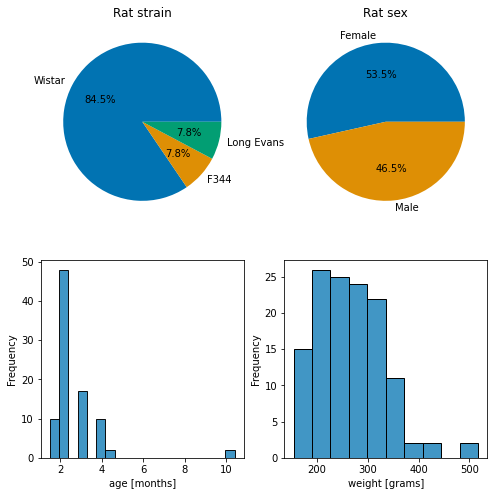

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))



ax1 = df['Sex'].value_counts().plot.pie(title='Rat sex',ax=axes[0,1],autopct="%.1f%%")
ax2 = df['Strain'].value_counts().plot.pie(title='Rat strain',ax=axes[0,0],autopct="%.1f%%")
ax3 = sns.histplot(data=df, x="Age",ax=axes[1,0])
ax4 = sns.histplot(data=df, x="Weight",ax=axes[1,1])

ax1.set(xlabel="", ylabel="")
ax2.set(xlabel="", ylabel="")
ax3.set(xlabel="age [months]", ylabel="Frequency")
ax4.set(xlabel="weight [grams]", ylabel="Frequency")

To do: breathing rate and heart rate!!

[Text(0.5, 0, ''), Text(0, 0.5, '')]

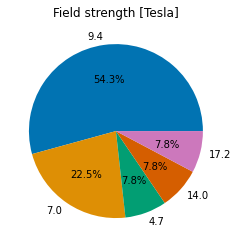

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

sns.set_palette("colorblind")

ax1 = df['Field_strength'].value_counts().plot.pie(title='Field strength [Tesla]', autopct="%.1f%%")

ax1.set(xlabel="", ylabel="")


Now let's examine tSNR and motion parameters

In [10]:
tsnr_map_path = os.path.join(analysis_folder, 'export_std', 'snr', 'tsnr')
tsnr_map = os.listdir(tsnr_map_path)

roiL = 520  # left barrel field cortex
roiR = 521  # right barrel field cortex


df["tsnr.S1"] = np.nan

# read the tSNR file output from RABIES and put them in the correct rows
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=i.split('_')[7]
    df.loc[df['SubjID'] == sub, ['tsnr.S1']]=np.double(tsnr_mean)

# let's do the same for subcortical ROIs
roiL = 731  # Striatum-L
roiR = 732  # Striatum-R

df["tsnr.str"] = np.nan
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=i.split('_')[7]
    df.loc[df['SubjID'] == sub, ['tsnr.str']]=np.double(tsnr_mean)

In [11]:
# then we extract the mean and max framewise displacement
MFW_map_path = os.path.join(analysis_folder, 'export_std', 'motion', 'FD')
MFW_map = os.listdir(MFW_map_path)

df["MFW"] = np.nan
df["maxFW"] = np.nan
for i in MFW_map:
    MFW_list = pd.read_csv(os.path.join(MFW_map_path, i),
                            delim_whitespace=False)
    MFW_mean = np.mean(MFW_list['Mean'])
    MFW_max = np.max(MFW_list['Mean'])
    sub=i.split('_')[0]
    df.loc[df['SubjID'] == sub, ['MFW']]=np.double(MFW_mean)
    df.loc[df['SubjID'] == sub, ['maxFW']]=np.double(MFW_max)

In [12]:
df.to_csv(df_path, sep='\t', index=False)

In [44]:
#remove excluded scans
df_exclude = df.loc[(df['exclude'] != 'yes')]

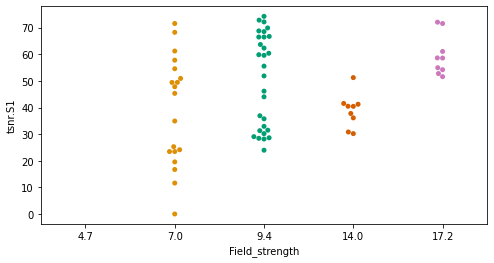

In [14]:
# plot S1 tSNR as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="Field_strength", y="tsnr.S1")


correlation between tSNR in cortex and striatum
0.6447239418014779


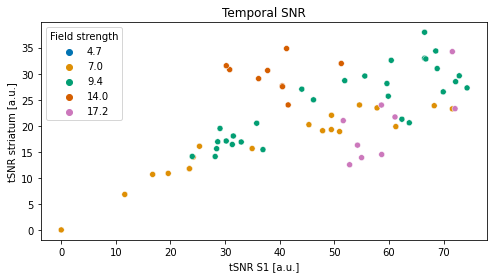

In [30]:
# does tSNR in the cortex correlate to tSNR in the striatum?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between tSNR in cortex and striatum')
print(df_exclude[['tsnr.S1','tsnr.str']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="tsnr.str", hue="Field_strength")

ax1.set(xlabel='tSNR S1 [a.u.]', ylabel='tSNR striatum [a.u.]', title='Temporal SNR')
ax1.get_legend().set_title('Field strength')

!! TO add Mean framewise displacement as a function of breathing rate!

correlation between MFW and breathing
-0.3399214292347006


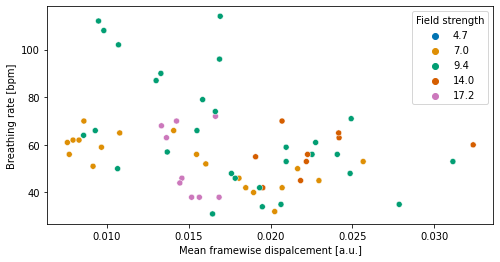

In [45]:
# does MFW correlate to breathing rate?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between MFW and breathing')
print(df_exclude[['MFW','Breathing_onset']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="MFW",
                    y="Breathing_onset", hue="Field_strength")

ax1.set(xlabel='Mean framewise dispalcement [a.u.]', ylabel='Breathing rate [bpm]', title='')


correlation between Max_FW and breathing
0.1297904600024668


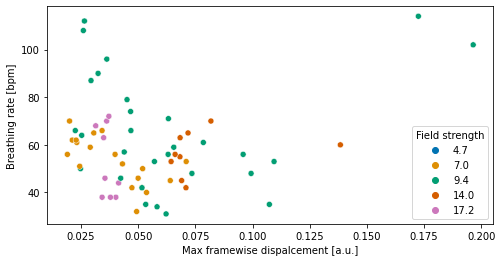

In [47]:
# does MaxFW correlate to breathing rate?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between Max_FW and breathing')
print(df_exclude[['maxFW','Breathing_onset']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="maxFW",
                    y="Breathing_onset", hue="Field_strength")

ax1.set(xlabel='Max framewise dispalcement [a.u.]', ylabel='Breathing rate [bpm]', title='')
ax1.get_legend().set_title('Field strength')

[Text(0.5, 0, 'Strain'),
 Text(0, 0.5, 'mean framewise displacement [a.u.]'),
 Text(0.5, 1.0, 'Motion')]

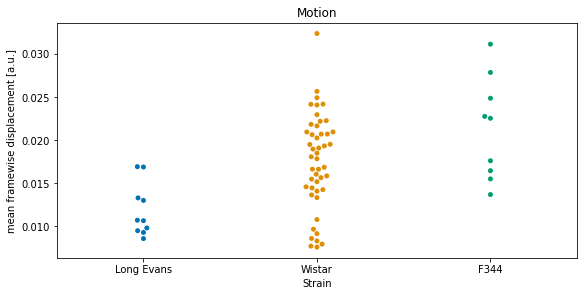

In [48]:
# plot mean framewise displacement as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4),constrained_layout=True)

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="Strain",
                    y="MFW")



ax1.set(xlabel='Strain', ylabel='mean framewise displacement [a.u.]', title='Motion')


# Functional MRI analysis
Finally!!!

In [49]:
# create empty columns for the different SBA parameters.
df['aromas_CPu_CPu'] = np.nan
df['aromas_MOp_MOp'] = np.nan
df['aromas_S1bf_S1bf'] = np.nan
df['aromas_S1bf_ACA'] = np.nan
df['aromas_S1bf_cat'] = np.nan

df['aromal_CPu_CPu'] = np.nan
df['aromal_MOp_MOp'] = np.nan
df['aromal_S1bf_S1bf'] = np.nan
df['aromal_S1bf_ACA'] = np.nan
df['aromal_S1bf_cat'] = np.nan

df['aromasr_CPu_CPu'] = np.nan
df['aromasr_MOp_MOp'] = np.nan
df['aromasr_S1bf_S1bf'] = np.nan
df['aromasr_S1bf_ACA'] = np.nan
df['aromasr_S1bf_cat'] = np.nan

df['WMCSFs_CPu_CPu'] = np.nan
df['WMCSFs_MOp_MOp'] = np.nan
df['WMCSFs_S1bf_S1bf'] = np.nan
df['WMCSFs_S1bf_ACA'] = np.nan
df['WMCSFs_S1bf_cat'] = np.nan

df['GSRs_CPu_CPu'] = np.nan
df['GSRs_MOp_MOp'] = np.nan
df['GSRs_S1bf_S1bf'] = np.nan
df['GSRs_S1bf_ACA'] = np.nan
df['GSRs_S1bf_cat'] = np.nan

In [50]:
roi_list = glob.glob((os.path.join(analysis_folder, 'template', 'roi'))+'/*')
seed_list = glob.glob((os.path.join(analysis_folder, 'export_std', 'seed','*'))+'/*')

In [51]:
import pandas as pd
pd.options.mode.chained_assignment = None

from nilearn.input_data import NiftiMasker
import re
import numpy as np

for i_orig in seed_list:
    #print(i_orig)
    i=i_orig.replace('_RAS','')
    i=i.replace('_aroma','')
    sub=os.path.basename(i).split('_')[0]
    denoise=i.split('/')[6]
    seed=os.path.basename(i).split('_')[5]
    if(seed =='ACA'):
        continue
    elif(seed =='S1bf'):
        roi='ACA'
        fc_orig=df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]
        fc_nan = np.isnan(fc_orig).all()
        if(fc_nan):
            r = re.compile('ACA'+'_l')
            nifti_mask=list(filter(r.findall, roi_list))[0]
            fc=NiftiMasker(nifti_mask).fit_transform(i_orig).mean()
            df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]=fc
    
    roi=seed
    fc_orig=df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]
    fc_nan = np.isnan(fc_orig).all()
    if(fc_nan):
        r = re.compile(seed+'_r')
        nifti_mask=list(filter(r.findall, roi_list))[0]
        fc=NiftiMasker(nifti_mask).fit_transform(i_orig).mean()
        df[(denoise+'_'+seed+'_'+roi)][df['SubjID']==sub]=fc
    
df.to_csv(df_path, sep='\t', index=False)

In [53]:

df_exclude = df.loc[(df['exclude'] != 'yes')]
df_exclude = df_exclude.head(67)

print('missing aromas')
print(df_exclude[np.isnan(df['aromas_S1bf_S1bf']) | np.isnan(df['aromas_S1bf_ACA']) | np.isnan(df['aromas_MOp_MOp'])  | np.isnan(df['aromas_CPu_CPu'])]['SubjID'].unique())

print('missing aromal')
print(df_exclude[np.isnan(df['aromal_S1bf_S1bf']) | np.isnan(df['aromal_S1bf_ACA']) | np.isnan(df['aromal_MOp_MOp'])  | np.isnan(df['aromal_CPu_CPu'])]['SubjID'].unique())

print('missing aromasr')
print(df_exclude[np.isnan(df['aromasr_S1bf_S1bf']) | np.isnan(df['aromasr_S1bf_ACA']) | np.isnan(df['aromasr_MOp_MOp'])  | np.isnan(df['aromasr_CPu_CPu'])]['SubjID'].unique())

print('missing WMCSFs')
print(df_exclude[np.isnan(df['WMCSFs_S1bf_S1bf']) | np.isnan(df['WMCSFs_S1bf_ACA']) | np.isnan(df['WMCSFs_MOp_MOp'])  | np.isnan(df['WMCSFs_CPu_CPu'])]['SubjID'].unique())

print('missing GSRs')
print(df_exclude[np.isnan(df['GSRs_S1bf_S1bf']) | np.isnan(df['GSRs_S1bf_ACA']) | np.isnan(df['GSRs_MOp_MOp'])  | np.isnan(df['GSRs_CPu_CPu'])]['SubjID'].unique())


missing aromas
['sub-300502']
missing aromal
['sub-300502']
missing aromasr
['sub-300502']
missing WMCSFs
['sub-300502']
missing GSRs
['sub-300502']


In [54]:
# This is a function to estimate functional connectivity specificity. See Grandjean 2020 for details on the reasoning 

def specific_FC(specific_roi, unspecific_ROI):
    if (specific_roi>=0.1) and (unspecific_ROI<0.1):
        cat='Specific'
    elif (specific_roi>=0.1) and (unspecific_ROI>=0.1):
        cat='Unspecific'
    elif (abs(specific_roi)<0.1) and (abs(unspecific_ROI)<0.1):
        cat='No'
    else:
        cat='Spurious'
    return cat



In [55]:
for i in list(range(0,df.shape[0])):
    #---- Now doing aromas condition
    specific=df['aromas_S1bf_S1bf'][i]
    unspecific=df['aromas_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromas_S1bf_cat'][i]=specific_FC(specific,unspecific)  
    
    #---- Now doing aromal condition
    specific=df['aromal_S1bf_S1bf'][i]
    unspecific=df['aromal_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromal_S1bf_cat'][i]=specific_FC(specific,unspecific)        
    
    #---- Now doing aromasr condition
    specific=df['aromasr_S1bf_S1bf'][i]
    unspecific=df['aromasr_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['aromasr_S1bf_cat'][i]=specific_FC(specific,unspecific)  
        
    #---- Now doing WMCSFs condition
    specific=df['WMCSFs_S1bf_S1bf'][i]
    unspecific=df['WMCSFs_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['WMCSFs_S1bf_cat'][i]=specific_FC(specific,unspecific)  
        
    #---- Now doing GSRs condition
    specific=df['GSRs_S1bf_S1bf'][i]
    unspecific=df['GSRs_S1bf_ACA'][i]
    if(np.isnan(specific) | np.isnan(unspecific)):
        print('')
    else:
        df['GSRs_S1bf_cat'][i]=specific_FC(specific,unspecific)  

df.to_csv(df_path, sep='\t', index=False)

In [56]:
#remove excluded scans
df_exclude = df.loc[(df['exclude'] != 'yes')]
df_exclude = df_exclude.head(67)

[Text(0.5, 0, ''), Text(0, 0.5, '')]

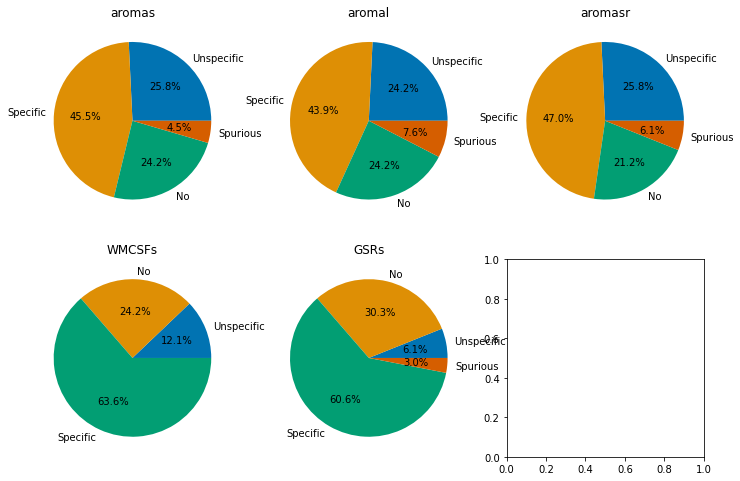

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

sns.set_palette("colorblind")

ax1 = df_exclude['aromas_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromas',ax=axes[0,0], autopct="%.1f%%")
ax2 = df_exclude['aromal_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromal',ax=axes[0,1],autopct="%.1f%%")    
ax3 = df_exclude['aromasr_S1bf_cat'].value_counts(sort=False).plot.pie(title='aromasr',ax=axes[0,2],autopct="%.1f%%")    
ax4 = df_exclude['WMCSFs_S1bf_cat'].value_counts(sort=False).plot.pie(title='WMCSFs',ax=axes[1,0],autopct="%.1f%%")    
ax5 = df_exclude['GSRs_S1bf_cat'].value_counts(sort=False).plot.pie(title='GSRs',ax=axes[1,1],autopct="%.1f%%")    


ax1.set(xlabel="", ylabel="")
ax2.set(xlabel="", ylabel="")
ax3.set(xlabel="", ylabel="")
ax4.set(xlabel="", ylabel="")
ax5.set(xlabel="", ylabel="")


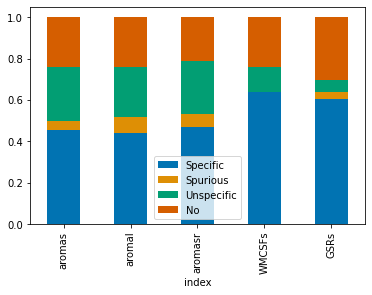

In [94]:
specificity_denoise= pd.concat([df_exclude['aromas_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromal_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromasr_S1bf_cat'].value_counts(sort=False),
                                df_exclude['WMCSFs_S1bf_cat'].value_counts(sort=False),
                                df_exclude['GSRs_S1bf_cat'].value_counts(sort=False)], axis=1)

specificity_denoise = specificity_denoise/specificity_denoise.sum()
specificity_denoise = specificity_denoise.rename(columns={"aromas_S1bf_cat": "aromas", "aromal_S1bf_cat": "aromal", "aromasr_S1bf_cat": "aromasr", "WMCSFs_S1bf_cat": "WMCSFs", "GSRs_S1bf_cat": "GSRs"})

specificity_denoise_T = specificity_denoise.T
specificity_denoise_T.reset_index(level=0, inplace=True) 
specificity_denoise_T = specificity_denoise_T[["index","Specific", "Spurious", "Unspecific","No"]]

specificity_denoise_T.set_index('index').plot(kind='bar', stacked=True)

#plt.savefig(os.path.join(init_folder,'assets','figure','Figure2C.svg'), format="svg", dpi=600)
plt.show()

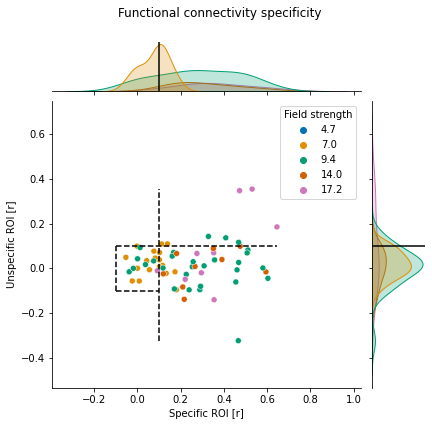

In [58]:
ax6 = sns.jointplot(data=df_exclude, x='WMCSFs_S1bf_S1bf', y='WMCSFs_S1bf_ACA', hue='Field_strength')
#ax6.plot_joint(sns.kdeplot,linestyles='dashed', zorder=0, levels=6)

sns.set_palette("colorblind")

ax6.fig.suptitle('Functional connectivity specificity')
ax6.fig.subplots_adjust(top=0.9)
ax6.ax_joint.set(xlabel='Specific ROI [r]', ylabel='Unspecific ROI [r]')
ax6.ax_joint.get_legend().set_title('Field strength')
ax6.ax_joint.vlines(0.1,ymin=min(df_exclude['WMCSFs_S1bf_ACA']),ymax=max(df_exclude['WMCSFs_S1bf_ACA']),linestyles='dashed', color='black')
ax6.ax_joint.vlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(0.1, -0.1,xmax=max(df_exclude['WMCSFs_S1bf_S1bf']),linestyles='dashed', color='black')
ax6.ax_marg_x.axvline(x=0.1, color='black')
ax6.ax_marg_y.axhline(y=0.1, color='black')

## Now doing a Chi2 test to see distribution of specificity among variables

From preregistration: 
"Specificity: parameter associated with connectivity specificity. 
Assuming S1 and Cg belong to distinct anti- (or minimally-) correlated networks, FC specificity will be determined the 4 quadrant system in Grandjean et al 2020. A ??2 test will be used to determine which factors (field strength, coil design, anesthesia, strain, gender) have a skewed distribution of specific FC. "

In [62]:
from scipy.stats import chi2_contingency
from math import sqrt

# now testing strain
chi_stack = df_exclude.groupby(['Strain', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Strain effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing sex
chi_stack = df_exclude.groupby(['Sex', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Sex effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing field strength
chi_stack = df_exclude.groupby(['Field_strength', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Field strength effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))



WMCSFs_S1bf_cat    No  Specific  Unspecific   sum  Specific_percent
Strain                                                             
Long Evans        0.0      10.0         0.0  10.0              1.00
Wistar           12.0      28.0         7.0  47.0              0.60
F344              4.0       4.0         1.0   9.0              0.44
Strain effect: g-value = 8.210064167510977 dof = 4 p-value = 0.08417937439777909 Phi = 0.247

WMCSFs_S1bf_cat  No  Specific  Unspecific  sum  Specific_percent
Sex                                                             
Female           11        27           4   42              0.64
Male              5        15           4   24              0.62
Sex effect: g-value = 0.831313775510204 dof = 2 p-value = 0.6599066536981153 Phi = 0.079

WMCSFs_S1bf_cat  No  Specific  Unspecific  sum  Specific_percent
Field_strength                                                  
14.0              0         9           0    9              1.00
9.4               6 

In [63]:
# now testing anesthesia.breathing.rate
df_exclude['breathing_bin']=pd.cut(df_exclude['Breathing_onset'],6)
chi_stack = df_exclude.groupby(['breathing_bin', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Breathing rate effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


# now testing Mean framewise displacement
df_exclude['MFW_bin']=pd.cut(df_exclude['MFW'],6)
chi_stack = df_exclude.groupby(['MFW_bin', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Mean framewise displacement effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing Max framewise displacement
df_exclude['maxFW_bin']=pd.cut(df_exclude['maxFW'],6)
chi_stack = df_exclude.groupby(['maxFW_bin', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Max framewise displacement effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing tSNR in S1
df_exclude['tsnr_bin']=pd.cut(df_exclude['tsnr.S1'],6)
chi_stack = df_exclude.groupby(['tsnr_bin', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('tSNR effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


WMCSFs_S1bf_cat    No  Specific  Unspecific  sum  Specific_percent
breathing_bin                                                     
(86.333, 100.167]   0         3           0    3              1.00
(100.167, 114.0]    0         4           0    4              1.00
(58.667, 72.5]      3        15           3   21              0.71
(44.833, 58.667]    7        15           0   22              0.68
(30.917, 44.833]    5         5           4   14              0.36
(72.5, 86.333]      1         0           1    2              0.00
Breathing rate effect: g-value = 18.1875 dof = 10 p-value = 0.05188195664831743 Phi = 0.366

WMCSFs_S1bf_cat    No  Specific  Unspecific  sum  Specific_percent
MFW_bin                                                           
(0.0283, 0.0324]    0         2           0    2              1.00
(0.00755, 0.0117]   3        10           1   14              0.71
(0.0241, 0.0283]    2         4           0    6              0.67
(0.02, 0.0241]      3         9    

In [64]:
# check how datasets are prefroming
chi_stack = df_exclude.groupby(['DatasetID', 
                    'WMCSFs_S1bf_cat']).size().unstack('WMCSFs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)

print("FC specificity distribution per dataset, WMCSFs denoising")
print(chi_stack["Specific_percent"].quantile([0.25,0.5,0.75]))
chi_stack.sort_values(by="Specific_percent",ascending=False)


FC specificity distribution per dataset, WMCSFs denoising
0.25    0.47
0.50    0.56
0.75    0.80
Name: Specific_percent, dtype: float64


WMCSFs_S1bf_cat,No,Specific,Unspecific,sum,Specific_percent
DatasetID,,,,,
3001,0.0,10.0,0.0,10.0,1.00
3006,0.0,9.0,0.0,9.0,1.00
3007,2.0,6.0,2.0,10.0,0.60
3005,1.0,5.0,3.0,9.0,0.56
3002,4.0,5.0,1.0,10.0,0.50
3004,4.0,4.0,1.0,9.0,0.44
3003,5.0,3.0,1.0,9.0,0.33


## Now looking at FC sensitivity

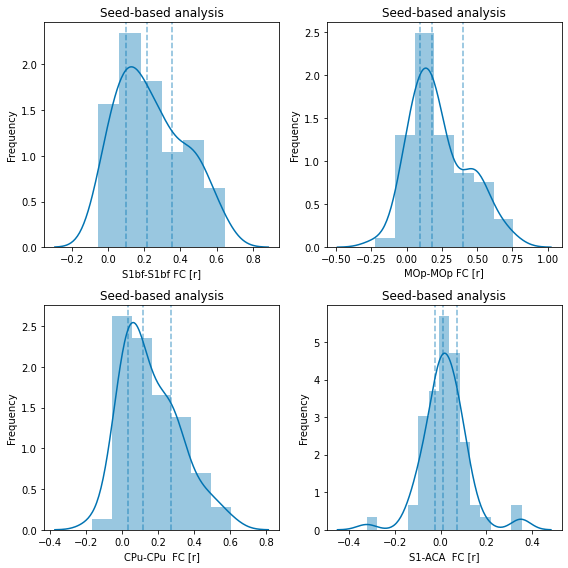

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
sns.set_palette("colorblind")

ax1 = sns.distplot(df_exclude['WMCSFs_S1bf_S1bf'],ax=axes[0,0])
ax2 = sns.distplot(df_exclude['WMCSFs_MOp_MOp'],ax=axes[0,1])
ax3 = sns.distplot(df_exclude['WMCSFs_CPu_CPu'],ax=axes[1,0])
ax4 = sns.distplot(df_exclude['WMCSFs_S1bf_ACA'],ax=axes[1,1])

ax1.set(xlabel='S1bf-S1bf FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax2.set(xlabel='MOp-MOp FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax3.set(xlabel='CPu-CPu  FC [r]', ylabel='Frequency', title='Seed-based analysis')
ax4.set(xlabel='S1-ACA  FC [r]', ylabel='Frequency', title='Seed-based analysis')

ax1.axvline(df_exclude['WMCSFs_S1bf_S1bf'].quantile(0.25),ls='--',alpha=0.5)
ax1.axvline(df_exclude['WMCSFs_S1bf_S1bf'].quantile(0.50),ls='--',alpha=0.5)
ax1.axvline(df_exclude['WMCSFs_S1bf_S1bf'].quantile(0.75),ls='--',alpha=0.5)

ax2.axvline(df_exclude['WMCSFs_MOp_MOp'].quantile(0.25),ls='--',alpha=0.5)
ax2.axvline(df_exclude['WMCSFs_MOp_MOp'].quantile(0.50),ls='--',alpha=0.5)
ax2.axvline(df_exclude['WMCSFs_MOp_MOp'].quantile(0.75),ls='--',alpha=0.5)


ax3.axvline(df_exclude['WMCSFs_CPu_CPu'].quantile(0.25),ls='--',alpha=0.5)
ax3.axvline(df_exclude['WMCSFs_CPu_CPu'].quantile(0.50),ls='--',alpha=0.5)
ax3.axvline(df_exclude['WMCSFs_CPu_CPu'].quantile(0.75),ls='--',alpha=0.5)

ax4.axvline(df_exclude['WMCSFs_S1bf_ACA'].quantile(0.25),ls='--',alpha=0.5)
ax4.axvline(df_exclude['WMCSFs_S1bf_ACA'].quantile(0.50),ls='--',alpha=0.5)
ax4.axvline(df_exclude['WMCSFs_S1bf_ACA'].quantile(0.75),ls='--',alpha=0.5)


plt.tight_layout()

In [66]:
#extracting quartiles for the functional connectivity parameters
df_exclude[['WMCSFs_S1bf_S1bf','WMCSFs_MOp_MOp','WMCSFs_CPu_CPu','WMCSFs_S1bf_ACA']].quantile([0.25,0.5,0.75])

,WMCSFs_S1bf_S1bf,WMCSFs_MOp_MOp,WMCSFs_CPu_CPu,WMCSFs_S1bf_ACA
0.25,0.101387,0.092996,0.034080,-0.024029
0.50,0.212908,0.182057,0.117205,0.011765
0.75,0.355920,0.396718,0.273074,0.069163


In [67]:
#extracting quartiles for the functional connectivity parameters
df_exclude[['GSRs_S1bf_S1bf','GSRs_MOp_MOp','GSRs_CPu_CPu','GSRs_S1bf_ACA']].quantile([0.25,0.5,0.75])

,GSRs_S1bf_S1bf,GSRs_MOp_MOp,GSRs_CPu_CPu,GSRs_S1bf_ACA
0.25,0.071210,0.076387,0.033951,-0.093072
0.50,0.184090,0.167906,0.112170,-0.031598
0.75,0.335151,0.395281,0.268167,0.020311


[Text(0.5, 0, 'Mean framewise displacement'), Text(0, 0.5, 'FC [r]')]

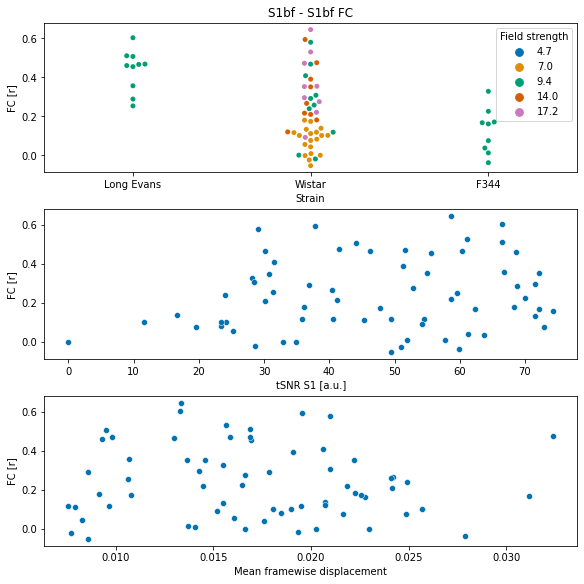

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
#plotting as a function of different parameters

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8, 8),constrained_layout=True)


sns.set_palette("colorblind")
df_exclude = df.loc[(df['exclude'] != 'yes')]

ax0 = sns.swarmplot(data=df_exclude, x="Strain",
                    y="WMCSFs_S1bf_S1bf", hue="Field_strength",ax=axes[0])
ax1 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="WMCSFs_S1bf_S1bf",ax=axes[1])

ax2 = sns.scatterplot(data=df_exclude, x="MFW",
                    y="WMCSFs_S1bf_S1bf",ax=axes[2])


ax0.set(xlabel='Strain', ylabel='FC [r]', title='S1bf - S1bf FC')
ax0.get_legend().set_title('Field strength')

ax1.set(xlabel='tSNR S1 [a.u.]', ylabel='FC [r]')

ax2.set(xlabel='Mean framewise displacement', ylabel='FC [r]')

#plt.constrained_layout()


## Group analysis. Estimating one sample t-test maps per datasets (session 1 exclusively). 
Images are exported as z-score image, thresholded z > 1.9 corresponding to p =< 0.05, one tailed, uncorrected (a very liberal threshold!) 

From preregistration: 
"Seed-based analysis voxel-wise analysis across the individual datasets
The seed-based analysis from the individual datasets (each consisting of n=10) will be examined with a more lenient parametric one-sample t-test (fsl_glm), without cluster correction and p-value threshold 0.05. This is to ensure that no FC is rejected (low false negative), but at the expense of a higher false-positive rate. The analysis across individual datasets will be summarized in an overlap map denoting the percentage of datasets reaching significance for each voxel. "


In [69]:
import re
from nilearn.image import concat_imgs, threshold_img,math_img, resample_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import pandas as pd


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')
maskimg = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Mask.nii')

# output folders
output_nii = os.path.join(analysis_folder, 'export_std', 'group_SBA')
output_img = os.path.join(analysis_folder, 'export_std', 'group_SBA_img')
os.makedirs(output_nii, exist_ok=True)
os.makedirs(output_img, exist_ok=True)


# re-read the table
df_exclude = df.loc[(df['exclude'] != 'yes')]

# re-read all seed files in the path.
condtion = 'WMCSFs'
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'export_std', 'seed', condtion))+'/*')
seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]


seed='S1bf'
i=3001



In [82]:
r = re.compile(seed)
seed_list_sub = list(filter(r.findall, seed_list))
r = re.compile(str(i))
seed_list_sub = list(filter(r.findall, seed_list_sub))
seed_list_sub

['/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300105_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300104_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300100_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300106_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300109_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300103_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300108_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300107_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.n

In [79]:
df_exclude['SubjID'].loc[df_exclude['DatasetID'] == i]

0    sub-300100
1    sub-300101
2    sub-300102
3    sub-300103
4    sub-300104
5    sub-300105
6    sub-300106
7    sub-300107
8    sub-300108
9    sub-300109
Name: SubjID, dtype: object

In [81]:
r = re.compile("(?=(" + "|".join(map(re.escape, map(str,df_exclude['SubjID'].loc[df_exclude['DatasetID'] == i]))) + "))")
seed_list_sub = list(filter(r.findall, seed_list_sub))
seed_list_sub

[]

In [86]:
combined

'(sub-300100)|(sub-300101)|(sub-300102)|(sub-300103)|(sub-300104)|(sub-300105)|(sub-300106)|(sub-300107)|(sub-300108)|(sub-300109)'

In [88]:
r = re.compile("(" + ")|(".join(df_exclude['SubjID'].loc[df_exclude['DatasetID'] == i]) + ")")

seed_list_sub = list(filter(r.findall, seed_list_sub))
seed_list_sub

['/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300105_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300104_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300100_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300106_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300109_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300103_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300108_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.nii.gz',
 '/project/4180000.19/multiRat/export_std/seed/WMCSFs/sub-300107_task-rest_bold_RAS_combined_cleaned_S1bf_l_corr_map.n

In [78]:
r = re.compile("(?=(" + "|".join(map(re.escape, map(str,
        df_exclude['DatasetID'] == i))) + "))")
seed_list_sub = list(filter(r.findall, seed_list_sub))
seed_list_sub

[]

In [ ]:
import re
from nilearn.image import concat_imgs, threshold_img,math_img, resample_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import pandas as pd


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')
maskimg = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Mask.nii')

# output folders
output_nii = os.path.join(analysis_folder, 'export_std', 'group_SBA')
output_img = os.path.join(analysis_folder, 'export_std', 'group_SBA_img')
os.makedirs(output_nii, exist_ok=True)
os.makedirs(output_img, exist_ok=True)

# re-read the table
df_exclude = df.loc[(df['exclude'] != 'yes')]

# re-read all seed files in the path.
condtion = 'WMCSFs'
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'export_std', 'seed', condtion))+'/*')
seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for i in list(df_exclude['DatasetID'].unique()):
    for count, seed in enumerate(seed_group):

        r = re.compile(seed)
        seed_list_sub = list(filter(r.findall, seed_list))
        r = re.compile(str(i))
        seed_list_sub = list(filter(r.findall, seed_list_sub))
        r = re.compile("(" + ")|(".join(df_exclude['SubjID'].loc[df_exclude['DatasetID'] == i]) + ")")
        seed_list_sub = list(filter(r.findall, seed_list_sub))
        
        maskimg_rs = resample_img(maskimg,interpolation='nearest', target_shape=(64, 109, 64), 
                        target_affine=np.array([[0.30000001,0.,-0., -9.43999958],
                        [0.,0.30000001,-0.,-17.80999947],
                        [0.,0.,0.30000001,-6.76499987],
                        [0.,0.,0.,1.]]))
        
        for count_seedlist, seed_indiv in enumerate(seed_list_sub):
            seed_indiv_rs = resample_img(seed_indiv, target_shape=(64, 109, 64), 
                        target_affine=np.array([[0.30000001,0.,-0., -9.43999958],
                        [0.,0.30000001,-0.,-17.80999947],
                        [0.,0.,0.30000001,-6.76499987],
                        [0.,0.,0.,1.]]))
            seed_indiv_rs.to_filename(seed_indiv)
    
        second_level_input = seed_list_sub
        design_matrix = pd.DataFrame([1] * len(seed_list_sub), columns=['intercept'])
        
        second_level_model = SecondLevelModel(mask_img=maskimg_rs) 
        
        second_level_model = second_level_model.fit(second_level_input,design_matrix=design_matrix)

        z_map = second_level_model.compute_contrast(output_type='z_score')
        
        filename_export = 'DS-'+str(i)+"_seed-"+seed
        filename_path = os.path.join(analysis_folder, 'export_std', output_nii, filename_export)

        z_map.to_filename(filename_path+'.nii.gz')

        filename_path = os.path.join(analysis_folder, 'export_std', output_img, filename_export)
        plot_stat_map(z_map, bg_img, title='DS:' + str(i) +', seed: ' + seed + ', n = '+ str(len(seed_list_sub)), threshold=1.9, vmax=5, symmetric_cbar=True, cmap='coolwarm', black_bg=False,cut_coords=(0, y_stack[count], 5),output_file=filename_path+'.svg')
        #remake plot with output to jupyter notebook if S1bf seed
        if(seed == 'S1bf'):
            plot_stat_map(z_map, bg_img,title='DS:' + str(i) + ', seed: ' + seed + ', n = '+ str(len(seed_list_sub)), threshold=1.9, vmax=5, symmetric_cbar=True, cmap='coolwarm',  black_bg=False, cut_coords=(0, y_stack[count], 5))

## Estimate incidence maps
Load one-sample t-test, threshold and perform mean across 4th dimension. 


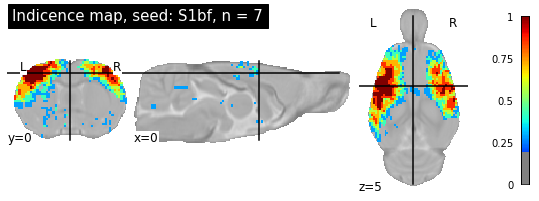

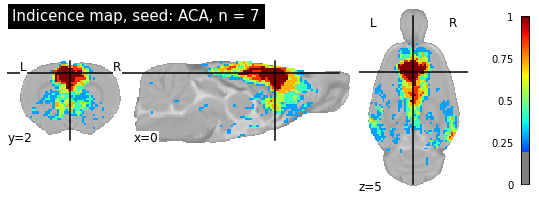

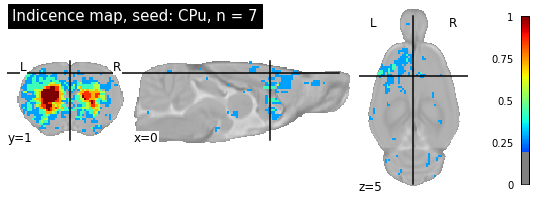

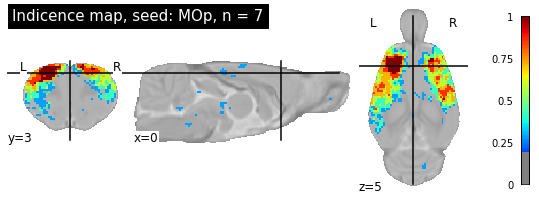

In [91]:
import re
from nilearn.image import concat_imgs, threshold_img,math_img
from nilearn.plotting import plot_stat_map
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# combine jet colormap for plot_stat_map (see https://stackoverflow.com/a/31052741)
# select to color scheme to use
colors1 = plt.cm.jet(np.linspace(0., 1, 128))
colors = np.vstack((colors1, colors1))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


bg_img = os.path.join(analysis_folder,
                      'template',
                      'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
                      'SIGMA_Rat_Anatomical_Imaging',
                      'SIGMA_Rat_Anatomical_InVivo_Template',
                      'SIGMA_InVivo_Brain_Template_Masked.nii')

# output folders
output_incidence = os.path.join(analysis_folder, 'export_std', 'group_SBA_incidence')
os.makedirs(output_incidence, exist_ok=True)

# read all one sample t-test files in the path.
seed_list = glob.glob(
    (os.path.join(analysis_folder, 'export_std', 'group_SBA'))+'/*')
seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]

for count,seed in enumerate(seed_group):

    filename_export = "seed-"+seed
    filename_path = os.path.join(analysis_folder, 'export_std', output_incidence, filename_export)

    r = re.compile(seed)
    seed_list_sub = list(filter(r.findall, seed_list))

    con_img = concat_imgs(seed_list_sub, auto_resample=True)
    th_img = math_img("img >=  1.9", img=con_img)
    ma_img = math_img("np.mean(img, axis=-1)", img=th_img)
    ma_img.to_filename(filename_path+'.nii.gz')

    #one for the save
    plot_stat_map(ma_img,
              bg_img,
              title='Indicence map, seed: ' + seed + ', n = '+ str(len(seed_list_sub)),
              threshold=0.2,
             vmax=1,
              symmetric_cbar=False,
              cmap=mymap,
              black_bg=False,
              # display_mode="y",
              cut_coords=(0, y_stack[count], 5))

    #one for jupyter export..    teeeeedious
    plot_stat_map(ma_img,
              bg_img,
              title='Indicence map, seed: ' + seed + ', n = '+ str(len(seed_list_sub)),
              threshold=0.2,
             vmax=1,
              symmetric_cbar=False,
              cmap=mymap,
              black_bg=False,
              # display_mode="y",
              cut_coords=(0,  y_stack[count], 5),
              output_file=filename_path+'.svg')